# 0-π oscillations in altermagnetic Josephson junctions

## Common imports


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from bodge import *


Bad key "text.kerning_factor" on line 4 in
/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Lattice construction
These functions take lattice coordinates $i, j ∈ \mathbb{N}^3$ as inputs, and for a given junction type (0º or 45º interfaces) determines whether a region is superconducting, normal metallic, or altermagnetic. Note that these functions depend on some global variables like `DIAG` and `L_SC`, which are used to alter the properties of the junctions investigated below. These variables are declared here but updated below.

In [2]:
# Whether the system has a diagonal interface.
DIAG = False

# Dimensions of the cubic lattice.
L_X = 0
L_Y = 0
L_Z = 0

# Superconductor length.
L_SC = 0 

# Normal-metal spacer length.
L_NM = 0

# Interlayer length. This can be an altermagnet.
L_IL = 0

This function calculates an "equivalent x-coordinate" for junctions with diagonal interfaces, defined as the x-coordinate at the center along the y-axis.

In [3]:
def diax(i):
    return i[0] + (i[1] - L_Y//2) * DIAG

These functions check whether a coordinate is superconducting, normal metallic, or altermagnetic.

In [4]:
def SC1(i):
    return diax(i) < L_SC
    
def SC2(i):
    return diax(i) >= L_X - L_SC

def NM1(i):
    return diax(i) < L_SC + L_NM and not SC1(i)

def NM2(i):
    return diax(i) >= L_X - L_SC - L_NM and not SC2(i)

def IL(i):
    return not SC1(i) and not SC2(i) and not NM1(i) and not NM2(i)

These functions let us calculate the y-integrated current in the middle of the first normal-metal layer, which we will use as a measure for the supercurrent. We calculate the current at $T = 0.01t$ for now.

In [13]:
def probe(i):
    return diax(i) == L_SC + L_NM//2

def current(system, N=600):
    F = FermiMatrix(system, N)(0.01)
    Jx = F.current_elec(axis=0)
    Jy = F.current_elec(axis=1)

    J = 0.0
    for i in lattice.sites():
        if probe(i):
            if DIAG:
                # Current in 45º direction.
                J += (Jx[i] + Jy[i])/np.sqrt(2)
            else:
                # Current in 0º direction.
                J += Jx[i]

    return J

We can also define a function for visualizing the lattices, to reduce the chance of errors. The evaluation point for currents is plotted in red.

In [14]:
def show():
    lattice = CubicLattice((L_X, L_Y, L_Z))

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_axis_off()

    for i in lattice.sites():
        if SC1(i) or SC2(i):
            ax.scatter(x=i[0], y=i[1], color='#ff7f00')
        if NM1(i) or NM2(i):
            ax.scatter(x=i[0], y=i[1], color='k')
        if IL(i):
            ax.scatter(x=i[0], y=i[1], color='#984ea3')
        if probe(i):
            ax.scatter(x=i[0], y=i[1], color='#ff0000')

    plt.show()

Let's test that these work as expected by plotting one diagonal and one non-diagonal lattice.

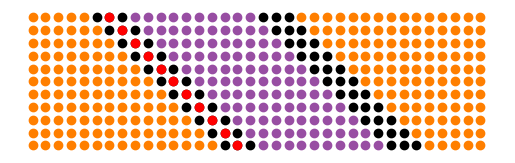

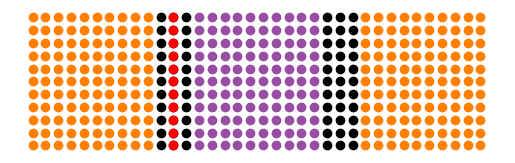

In [15]:
L_SC = 10 
L_NM = 3
L_IL = 10

L_X = 2 * L_SC + 2 * L_NM + L_IL
L_Y = 11
L_Z = 1

DIAG = True

show()

DIAG = False

show()

## Normal-metal baseline


For comparison to the altermagnetic case, let's do a quick run on normal metals (which have no 0-π oscillations). Based on separate benchmarks of the Chebyshev code, we should use 600 polynomials at least for explorative current calculations and perhaps 2000 for final ones.

First, let's define the tight-binding parameters:

In [16]:
t = 1.0
μ = -t/2
Δ0 = -t
δφ = π/2

  0%|          | 0/15 [00:00<?, ?it/s]

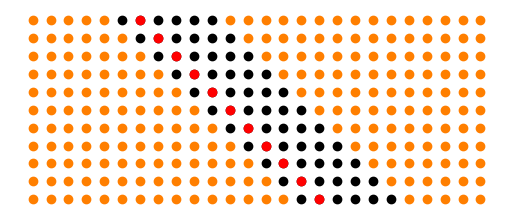

  7%|▋         | 1/15 [00:04<00:57,  4.10s/it]

	J/t = 2.1054527770140794


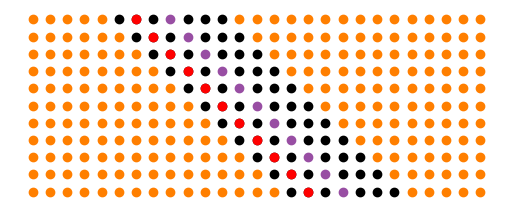

 13%|█▎        | 2/15 [00:08<00:55,  4.26s/it]

	J/t = 1.7319580338619565


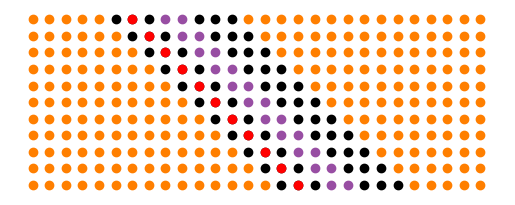

 20%|██        | 3/15 [00:13<00:53,  4.47s/it]

	J/t = 1.6324735235659205


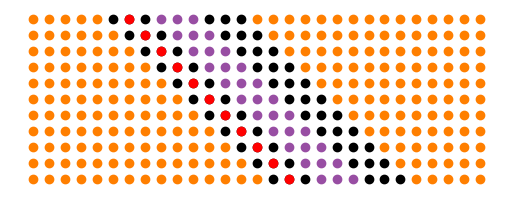

 27%|██▋       | 4/15 [00:18<00:50,  4.63s/it]

	J/t = 1.3500947640446204


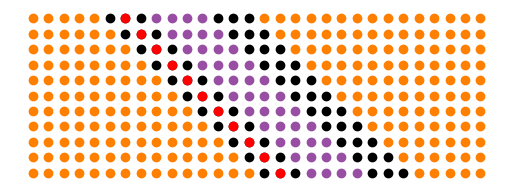

 33%|███▎      | 5/15 [00:23<00:48,  4.87s/it]

	J/t = 1.2869597063363807


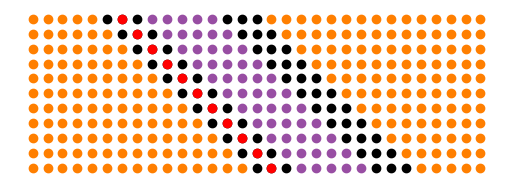

 40%|████      | 6/15 [00:28<00:45,  5.11s/it]

	J/t = 1.0916204859427716


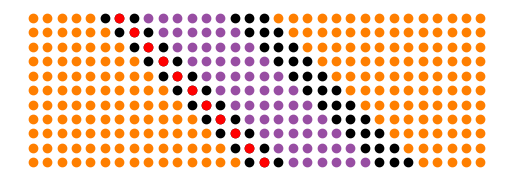

 47%|████▋     | 7/15 [00:34<00:42,  5.34s/it]

	J/t = 1.0317361459776897


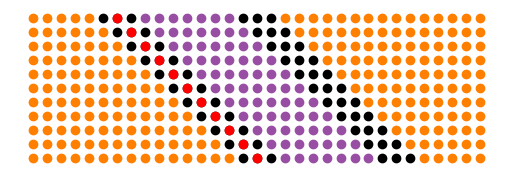

 53%|█████▎    | 8/15 [00:40<00:39,  5.61s/it]

	J/t = 0.8977127126779609


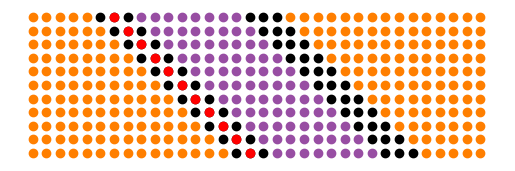

 60%|██████    | 9/15 [00:47<00:35,  5.91s/it]

	J/t = 0.8380375504004969


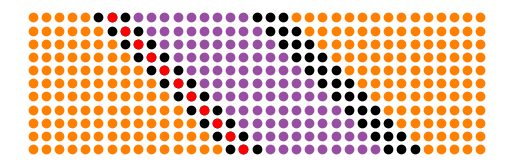

 67%|██████▋   | 10/15 [00:54<00:30,  6.18s/it]

	J/t = 0.7511138582419754


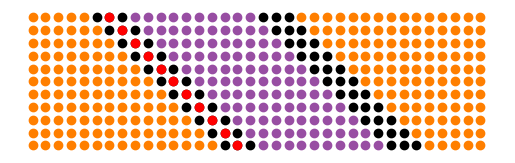

 73%|███████▎  | 11/15 [01:01<00:26,  6.51s/it]

	J/t = 0.6910820516843881


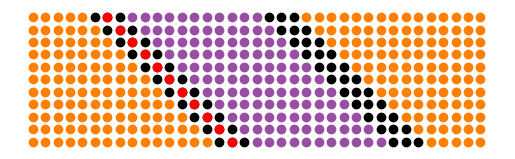

 80%|████████  | 12/15 [01:09<00:20,  6.81s/it]

	J/t = 0.6390489600732098


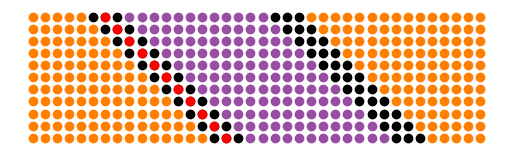

 87%|████████▋ | 13/15 [01:16<00:14,  7.14s/it]

	J/t = 0.5753538934072667


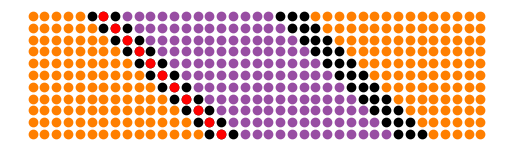

 93%|█████████▎| 14/15 [01:25<00:07,  7.46s/it]

	J/t = 0.5423978356356611


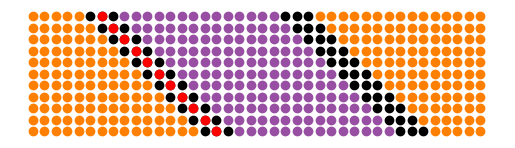

100%|██████████| 15/15 [01:33<00:00,  6.26s/it]


	J/t = 0.48201850325690276


  0%|          | 0/15 [00:00<?, ?it/s]

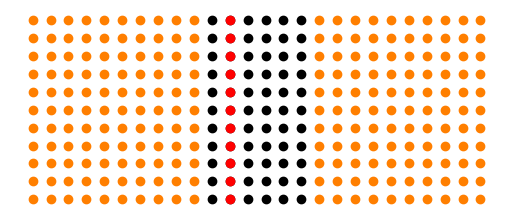

  7%|▋         | 1/15 [00:04<00:56,  4.04s/it]

	J/t = 1.718350173392475


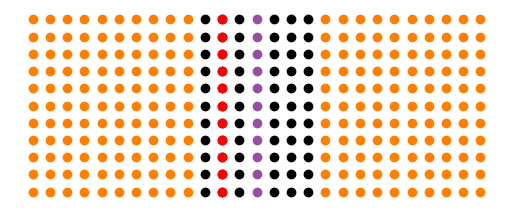

 13%|█▎        | 2/15 [00:08<00:54,  4.21s/it]

	J/t = 1.5594561633435444


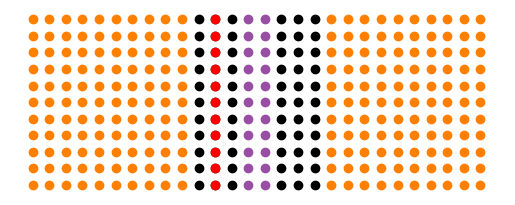

 20%|██        | 3/15 [00:13<00:53,  4.47s/it]

	J/t = 1.3717286402088122


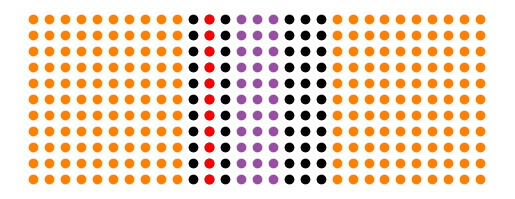

 27%|██▋       | 4/15 [00:18<00:51,  4.65s/it]

	J/t = 1.1990020416160128


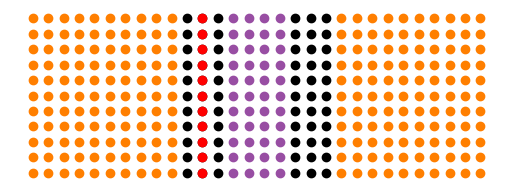

 33%|███▎      | 5/15 [00:23<00:48,  4.88s/it]

	J/t = 1.0682796925255895


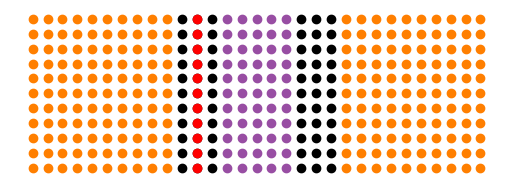

 40%|████      | 6/15 [00:28<00:46,  5.13s/it]

	J/t = 1.1238186387239417


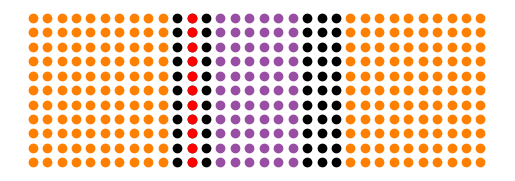

 47%|████▋     | 7/15 [00:34<00:42,  5.36s/it]

	J/t = 0.8780143857604135


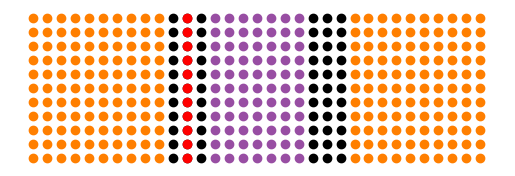

 53%|█████▎    | 8/15 [00:40<00:39,  5.62s/it]

	J/t = 0.9311219687853447


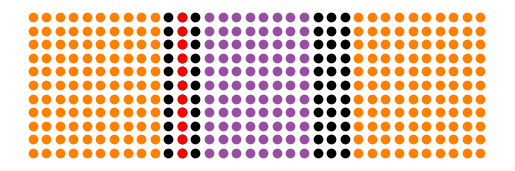

 60%|██████    | 9/15 [00:47<00:35,  5.92s/it]

	J/t = 0.7672056663430806


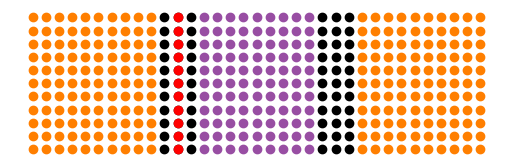

 67%|██████▋   | 10/15 [00:54<00:30,  6.19s/it]

	J/t = 0.7571306377176897


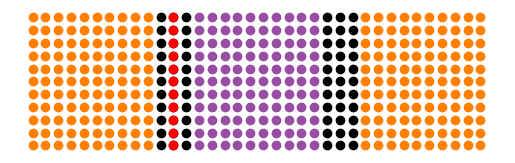

 73%|███████▎  | 11/15 [01:01<00:26,  6.51s/it]

	J/t = 0.7267751433442634


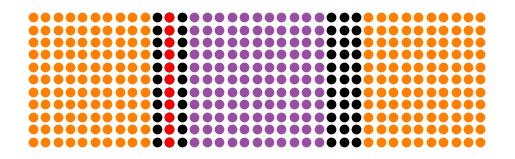

 80%|████████  | 12/15 [01:09<00:20,  6.81s/it]

	J/t = 0.6402581628859498


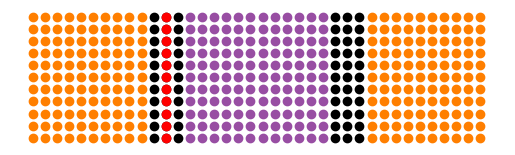

 87%|████████▋ | 13/15 [01:17<00:14,  7.15s/it]

	J/t = 0.6013955900272743


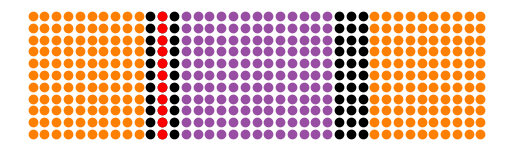

 93%|█████████▎| 14/15 [01:25<00:07,  7.48s/it]

	J/t = 0.5727597872720602


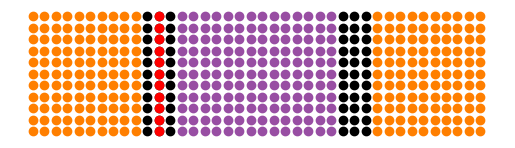

100%|██████████| 15/15 [01:33<00:00,  6.26s/it]

	J/t = 0.5372592411987538


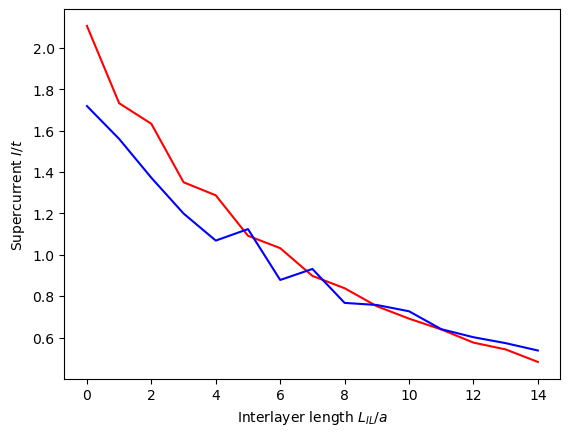

In [19]:
LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(15):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0
                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

This shows a qualitatively similar behavior for S/N/S junctions with the two different types of interfaces, although the curves quantitatively differ by perhaps 10% or so.

## Ferromagnetic baseline

Let's now try to use a ferromagnetic interlayer and repeat the experiment above. The point is to show that we can get 0-π oscillations for both types of interfaces, as a comparison for the altermagnets.

In [20]:
m = 3 * t / 2

  0%|          | 0/19 [00:00<?, ?it/s]

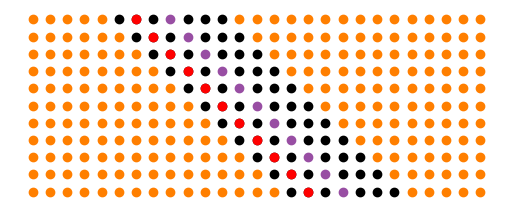

  5%|▌         | 1/19 [00:04<01:20,  4.49s/it]

	J/t = 1.446852962604257


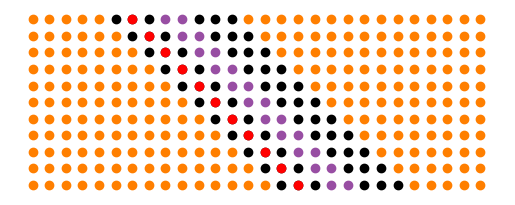

 11%|█         | 2/19 [00:09<01:17,  4.54s/it]

	J/t = -0.3412157641702257


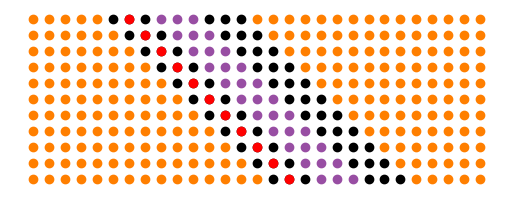

 16%|█▌        | 3/19 [00:13<01:14,  4.68s/it]

	J/t = -1.172142659521421


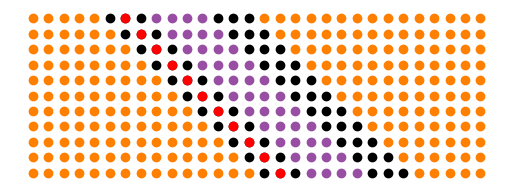

 21%|██        | 4/19 [00:19<01:13,  4.91s/it]

	J/t = -0.7815620301294719


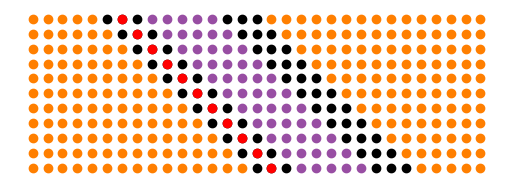

 26%|██▋       | 5/19 [00:24<01:12,  5.15s/it]

	J/t = -0.3734040923316378


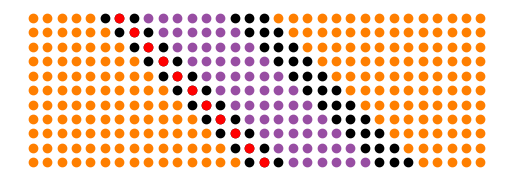

 32%|███▏      | 6/19 [00:30<01:10,  5.41s/it]

	J/t = 0.21008918979496363


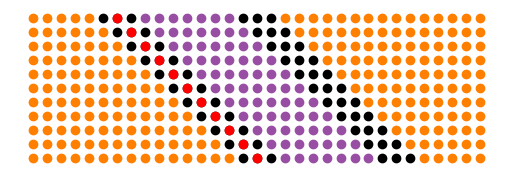

 37%|███▋      | 7/19 [00:36<01:07,  5.66s/it]

	J/t = 0.5325817651437589


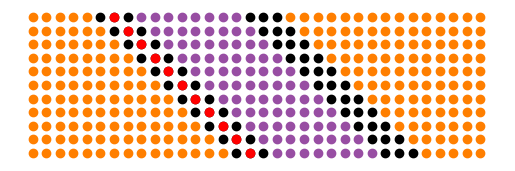

 42%|████▏     | 8/19 [00:43<01:05,  5.93s/it]

	J/t = 0.414621327837591


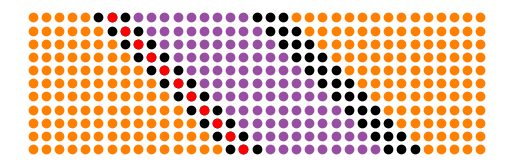

 47%|████▋     | 9/19 [00:50<01:02,  6.24s/it]

	J/t = 0.1510678714346215


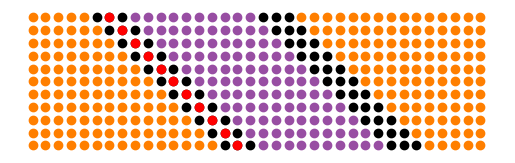

 53%|█████▎    | 10/19 [00:57<00:58,  6.54s/it]

	J/t = -0.16593750485424769


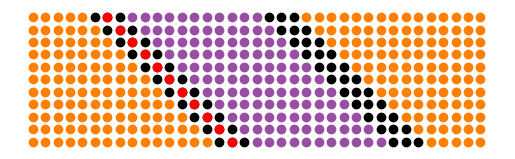

 58%|█████▊    | 11/19 [01:05<00:54,  6.85s/it]

	J/t = -0.3015075763342468


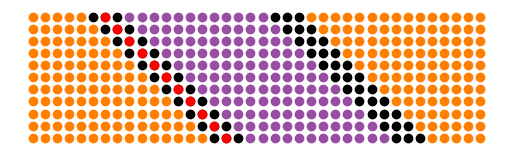

 63%|██████▎   | 12/19 [01:12<00:50,  7.16s/it]

	J/t = -0.2131085025126429


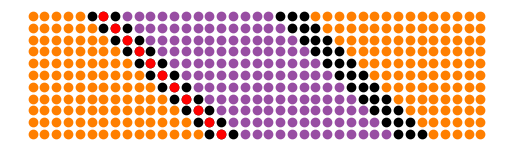

 68%|██████▊   | 13/19 [01:21<00:45,  7.51s/it]

	J/t = -0.06303873992244634


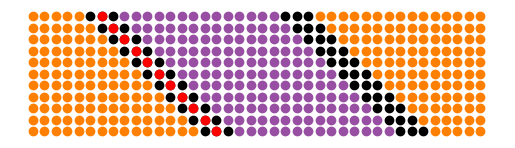

 74%|███████▎  | 14/19 [01:29<00:39,  7.83s/it]

	J/t = 0.08691959332052324


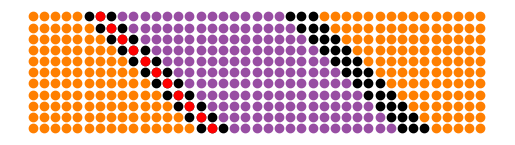

 79%|███████▉  | 15/19 [01:39<00:33,  8.26s/it]

	J/t = 0.12166318776845345


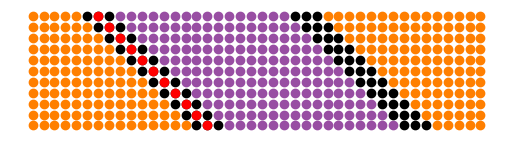

 84%|████████▍ | 16/19 [01:48<00:26,  8.69s/it]

	J/t = 0.07898210503082745


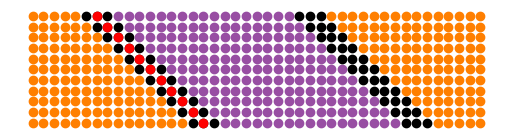

 89%|████████▉ | 17/19 [01:58<00:18,  9.06s/it]

	J/t = 0.02893392815186621


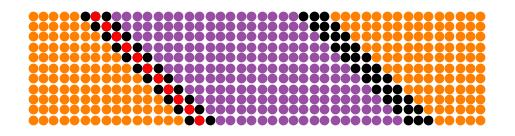

 95%|█████████▍| 18/19 [02:08<00:09,  9.40s/it]

	J/t = -0.01582529646088364


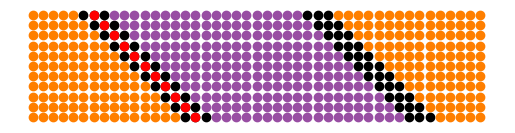

100%|██████████| 19/19 [02:19<00:00,  7.35s/it]


	J/t = -0.04255246253505323


  0%|          | 0/19 [00:00<?, ?it/s]

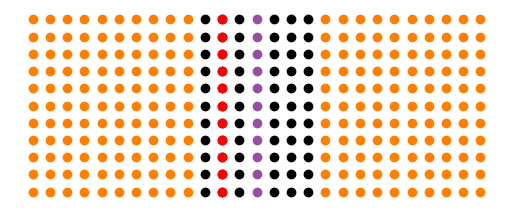

  5%|▌         | 1/19 [00:04<01:17,  4.32s/it]

	J/t = 0.21368022807017908


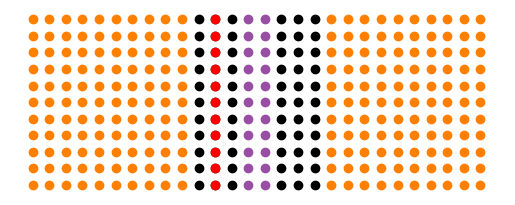

 11%|█         | 2/19 [00:08<01:16,  4.50s/it]

	J/t = -0.7548923949285613


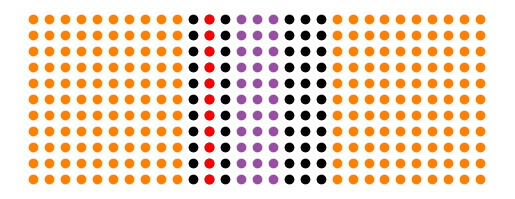

 16%|█▌        | 3/19 [00:13<01:15,  4.73s/it]

	J/t = 0.11859098275351548


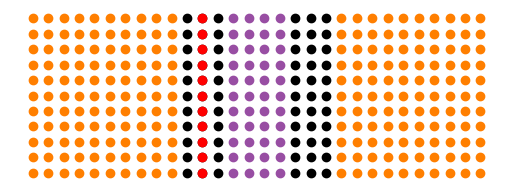

 21%|██        | 4/19 [00:19<01:14,  4.95s/it]

	J/t = 0.24045893393485485


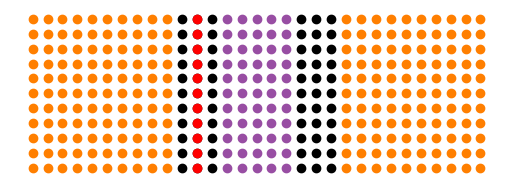

 26%|██▋       | 5/19 [00:24<01:12,  5.16s/it]

	J/t = -0.17073417275018396


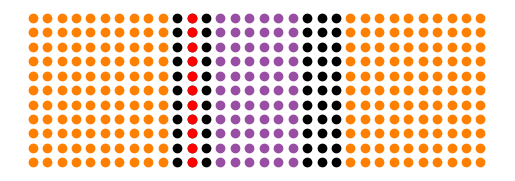

 32%|███▏      | 6/19 [00:30<01:10,  5.42s/it]

	J/t = -0.11132901000496105


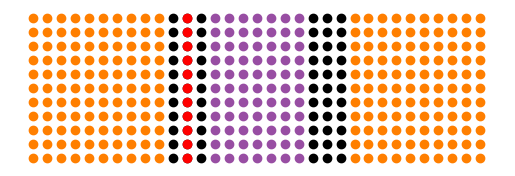

 37%|███▋      | 7/19 [00:36<01:07,  5.66s/it]

	J/t = 0.07654988729142254


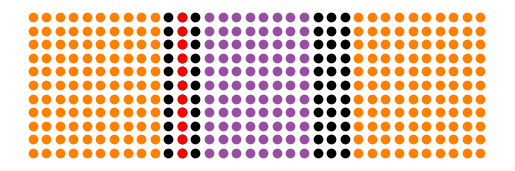

 42%|████▏     | 8/19 [00:43<01:05,  5.95s/it]

	J/t = 0.00653851360264462


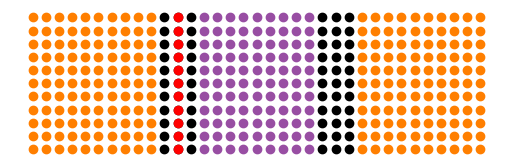

 47%|████▋     | 9/19 [00:50<01:02,  6.23s/it]

	J/t = -0.07142697677262135


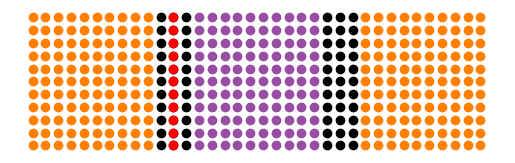

 53%|█████▎    | 10/19 [00:57<00:58,  6.52s/it]

	J/t = -0.028113097605302555


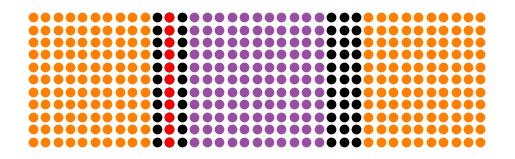

 58%|█████▊    | 11/19 [01:04<00:54,  6.84s/it]

	J/t = 0.017162680447243298


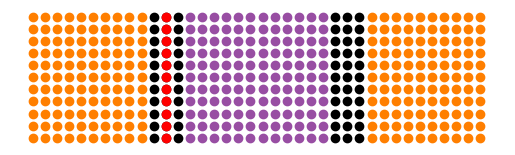

 63%|██████▎   | 12/19 [01:12<00:49,  7.14s/it]

	J/t = 0.010436069183513296


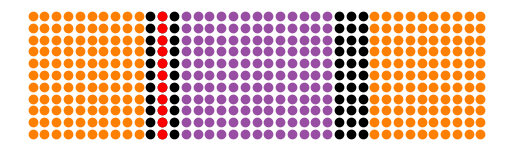

 68%|██████▊   | 13/19 [01:21<00:45,  7.53s/it]

	J/t = -0.024766409296918646


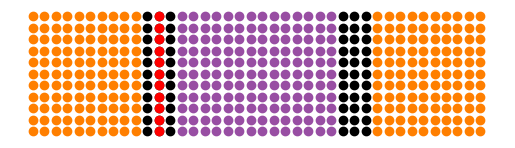

 74%|███████▎  | 14/19 [01:29<00:39,  7.83s/it]

	J/t = -0.0217900505595068


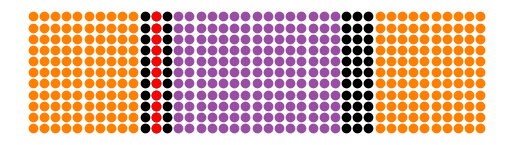

 79%|███████▉  | 15/19 [01:38<00:32,  8.23s/it]

	J/t = 0.021022574207454528


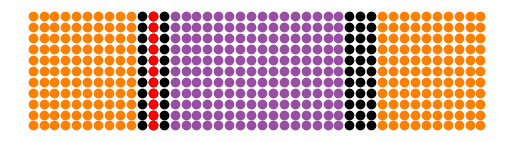

 84%|████████▍ | 16/19 [01:48<00:25,  8.62s/it]

	J/t = 0.015119206786283295


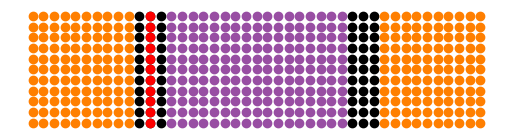

 89%|████████▉ | 17/19 [01:58<00:18,  9.01s/it]

	J/t = -0.025186022269187983


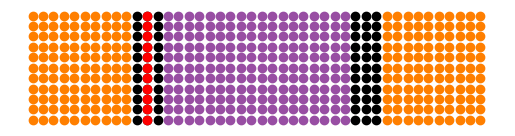

 95%|█████████▍| 18/19 [02:08<00:09,  9.36s/it]

	J/t = -0.007891914935838958


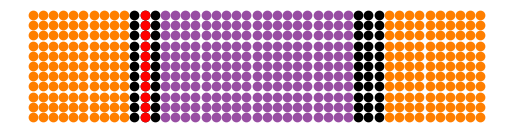

100%|██████████| 19/19 [02:19<00:00,  7.34s/it]

	J/t = 0.025825215439378824


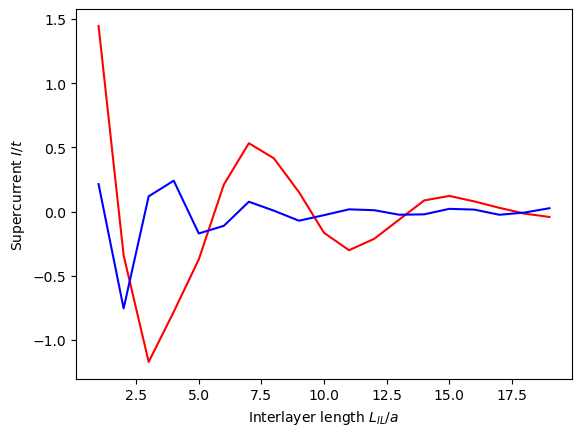

In [22]:
LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(1, 20):
        L_Y = 11
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                if IL(i):
                    H[i, i] = -μ * σ0 - m * σ3
                else:
                    H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)
            for i, j in lattice.bonds():
                H[i, j] = -t * σ0
        
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

Clearly, the interface type changes the period drastically, but 0-π oscillations occurs for both.

## Altermagnetic test for δφ = π/2


  0%|          | 0/19 [00:00<?, ?it/s]

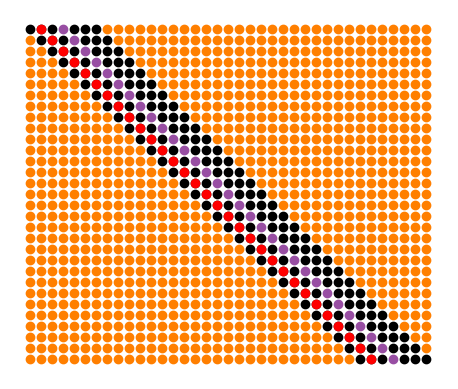

  5%|▌         | 1/19 [00:52<15:43, 52.44s/it]

	J/t = 5.5730716901000505


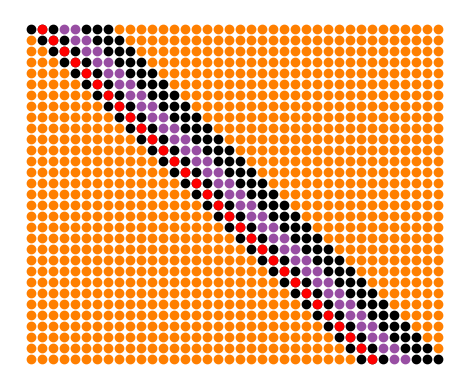

 11%|█         | 2/19 [01:47<15:14, 53.78s/it]

	J/t = 2.1089352222896194


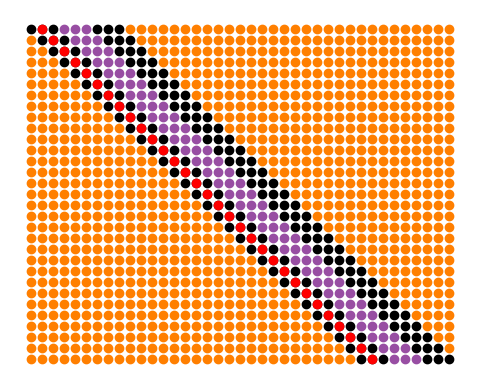

 16%|█▌        | 3/19 [02:44<14:48, 55.53s/it]

	J/t = -1.4202821161118624


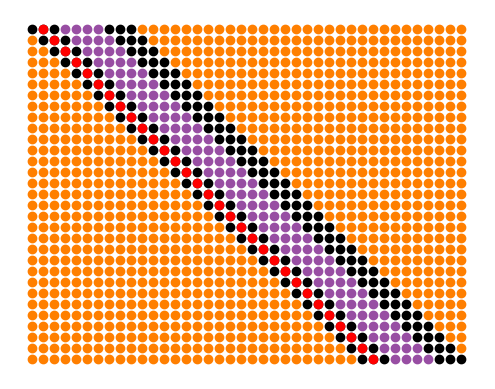

 21%|██        | 4/19 [03:45<14:21, 57.42s/it]

	J/t = -0.06796535702298377


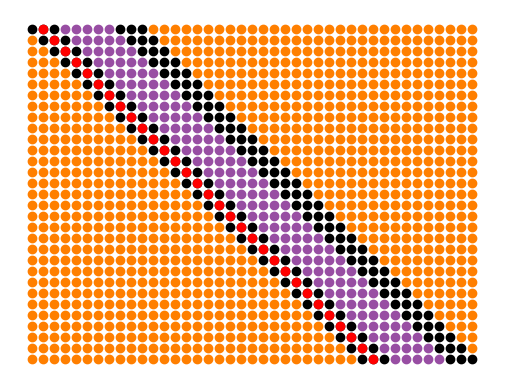

 26%|██▋       | 5/19 [04:51<14:08, 60.58s/it]

	J/t = -0.24481322799057073


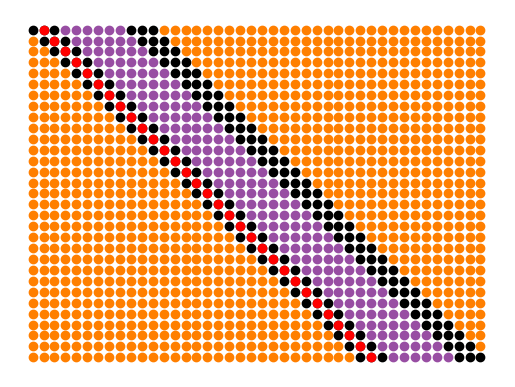

 32%|███▏      | 6/19 [06:01<13:50, 63.86s/it]

	J/t = -0.08200762725691271


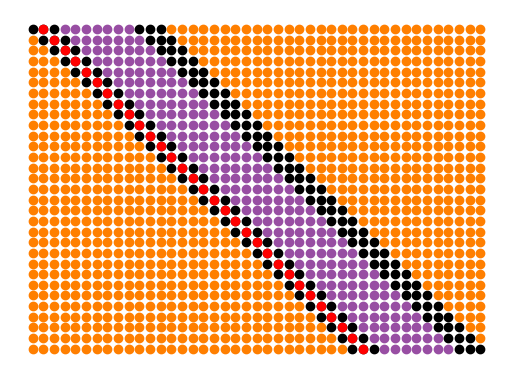

 37%|███▋      | 7/19 [07:13<13:18, 66.57s/it]

	J/t = 0.18162465449839305


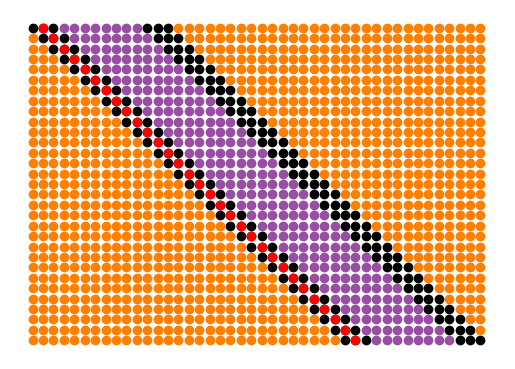

 42%|████▏     | 8/19 [08:28<12:39, 69.06s/it]

	J/t = -0.010323879468562181


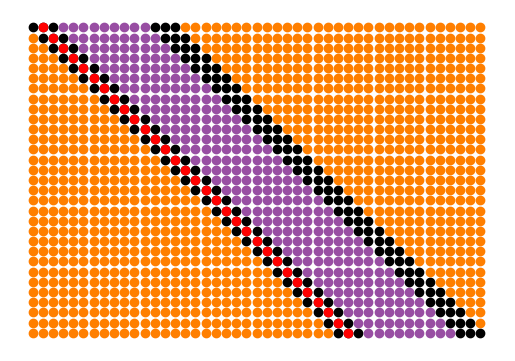

 47%|████▋     | 9/19 [09:44<11:54, 71.41s/it]

	J/t = 0.021921829505032017


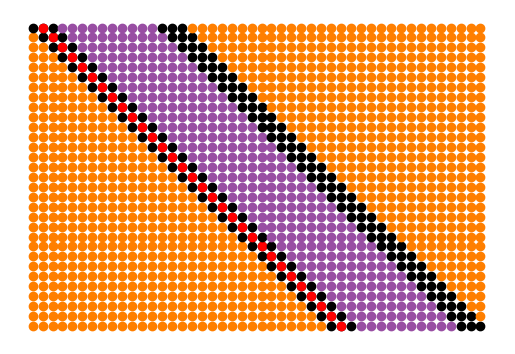

 53%|█████▎    | 10/19 [11:04<11:06, 74.08s/it]

	J/t = 0.0024776247708690616


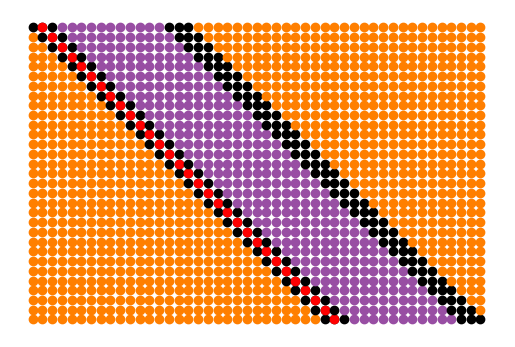

 58%|█████▊    | 11/19 [12:27<10:13, 76.64s/it]

	J/t = -0.013075478368250095


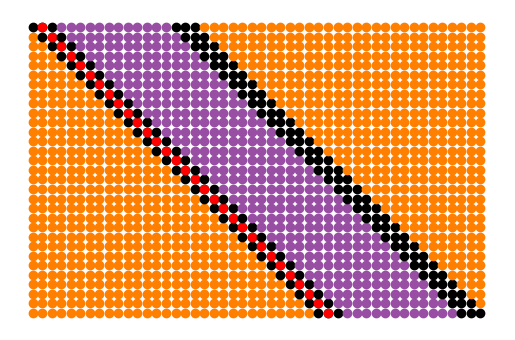

 63%|██████▎   | 12/19 [13:52<09:15, 79.37s/it]

	J/t = 0.004852623756192893


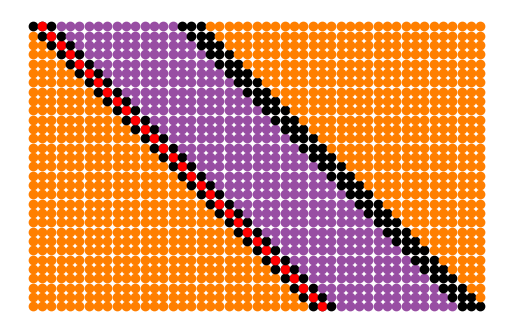

 68%|██████▊   | 13/19 [15:22<08:14, 82.39s/it]

	J/t = -0.008248766376777725


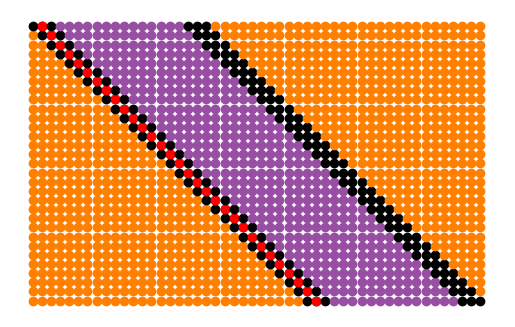

 74%|███████▎  | 14/19 [16:57<07:12, 86.43s/it]

	J/t = -0.009317115478549584


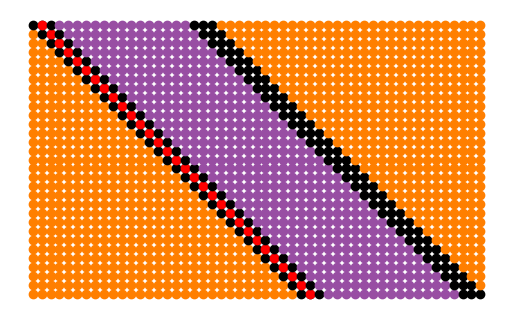

 79%|███████▉  | 15/19 [18:38<06:02, 90.63s/it]

	J/t = -0.00143986510946764


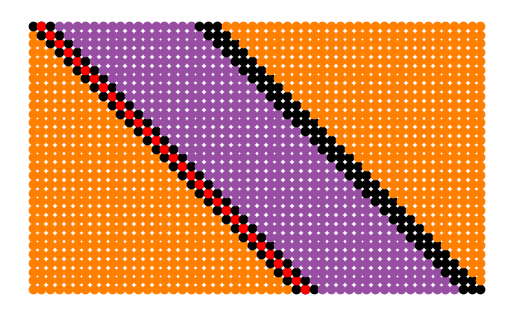

 84%|████████▍ | 16/19 [20:19<04:41, 93.84s/it]

	J/t = -0.00909154650668019


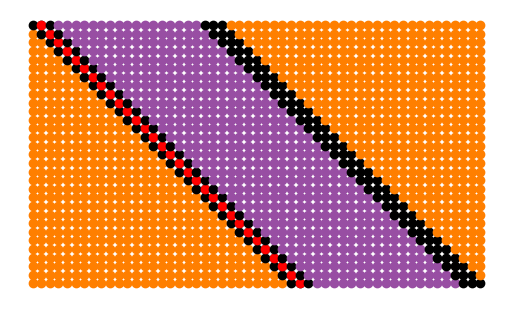

 89%|████████▉ | 17/19 [22:03<03:13, 96.98s/it]

	J/t = -0.0056959353492318475


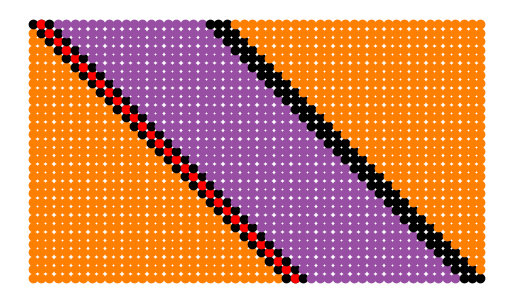

 95%|█████████▍| 18/19 [23:51<01:40, 100.32s/it]

	J/t = -0.009366771488321346


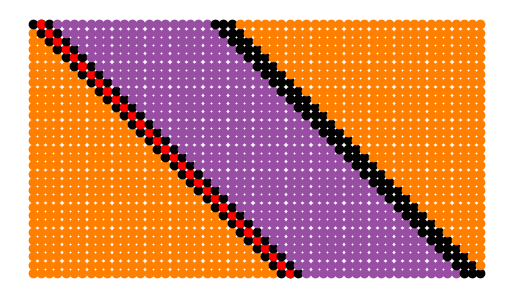

100%|██████████| 19/19 [25:43<00:00, 81.25s/it] 


	J/t = -0.0061737549328098095


  0%|          | 0/19 [00:00<?, ?it/s]

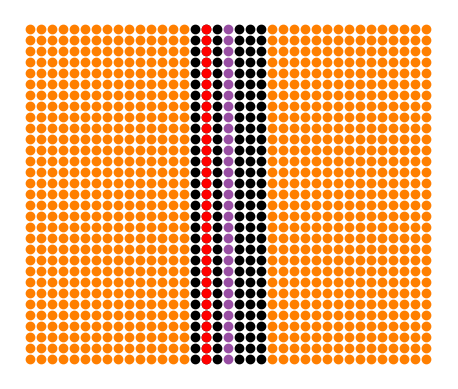

  5%|▌         | 1/19 [00:52<15:46, 52.58s/it]

	J/t = 1.9204884886978553


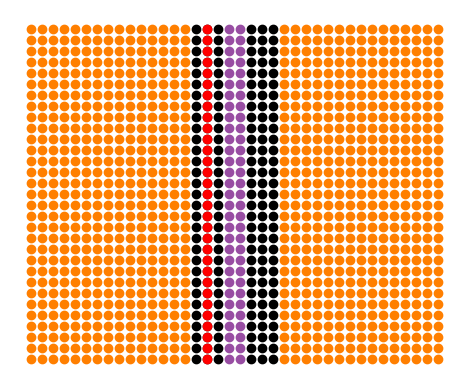

 11%|█         | 2/19 [01:46<15:11, 53.63s/it]

	J/t = -0.09729743458515608


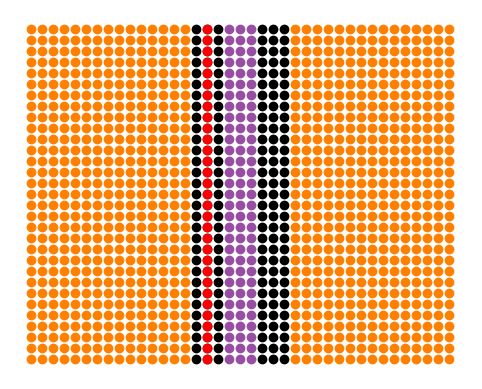

 16%|█▌        | 3/19 [02:44<14:47, 55.48s/it]

	J/t = -0.08593987541693293


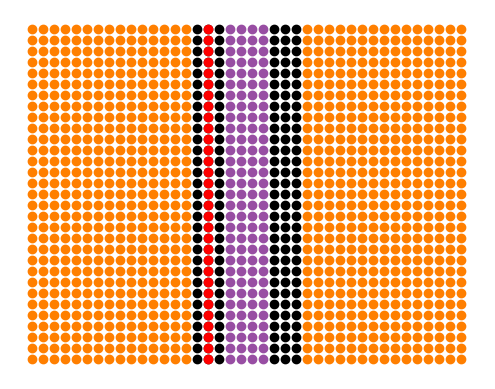

 21%|██        | 4/19 [03:44<14:20, 57.37s/it]

	J/t = 0.08968741701153439


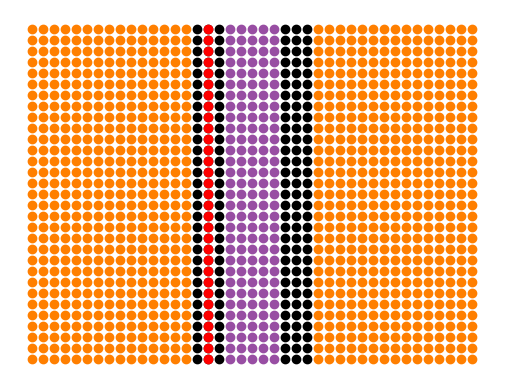

 26%|██▋       | 5/19 [04:50<14:06, 60.50s/it]

	J/t = 0.1286120690460058


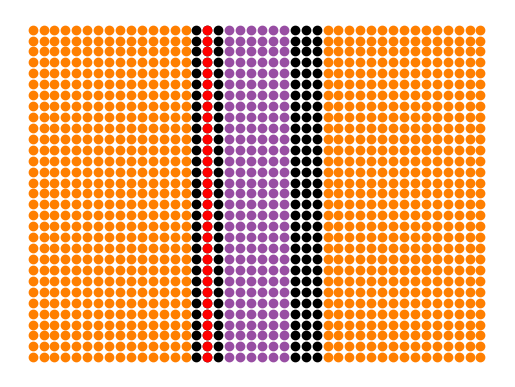

 32%|███▏      | 6/19 [06:02<13:53, 64.13s/it]

	J/t = -0.008076724657090965


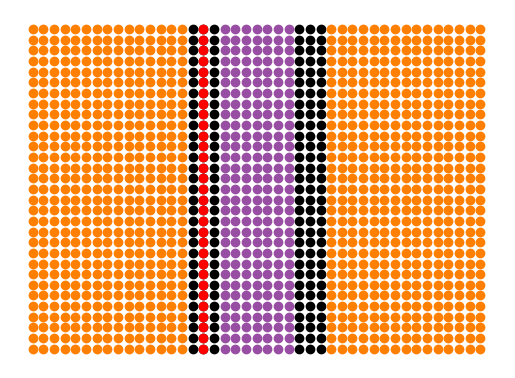

 37%|███▋      | 7/19 [07:14<13:23, 66.94s/it]

	J/t = -0.05675724054232948


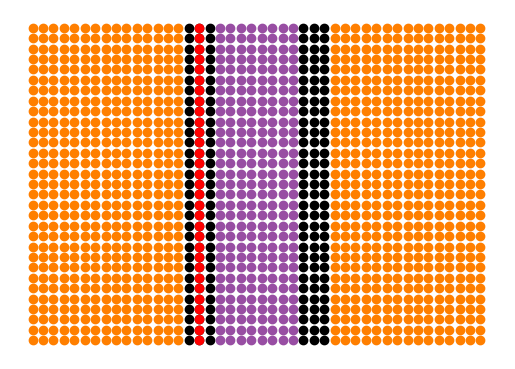

 42%|████▏     | 8/19 [08:29<12:43, 69.38s/it]

	J/t = 0.08400896912853767


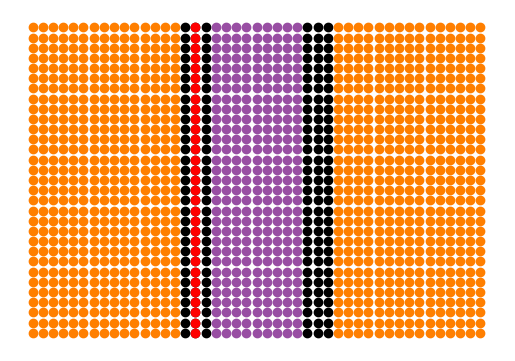

 47%|████▋     | 9/19 [09:45<11:55, 71.53s/it]

	J/t = -0.03500666513865512


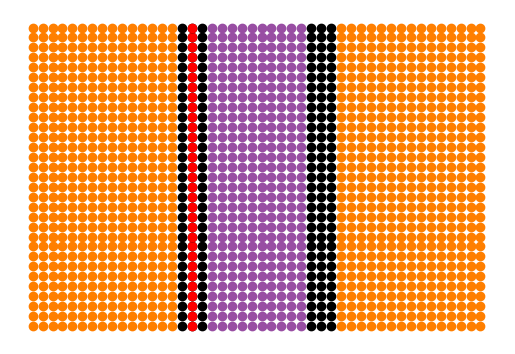

 53%|█████▎    | 10/19 [11:05<11:07, 74.18s/it]

	J/t = -0.025026047461332263


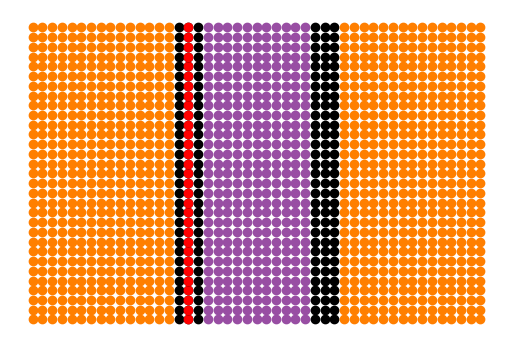

 58%|█████▊    | 11/19 [12:28<10:14, 76.78s/it]

	J/t = -0.034969670318431956


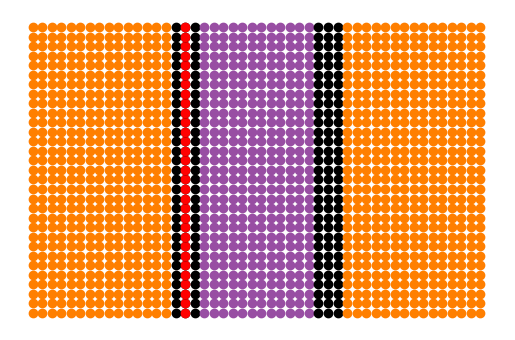

 63%|██████▎   | 12/19 [13:54<09:16, 79.49s/it]

	J/t = 0.03794524252016855


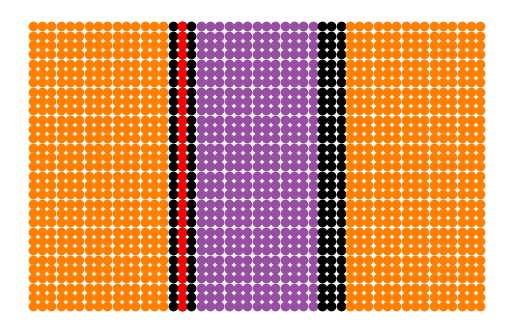

 68%|██████▊   | 13/19 [15:23<08:14, 82.46s/it]

	J/t = -0.09719845219097722


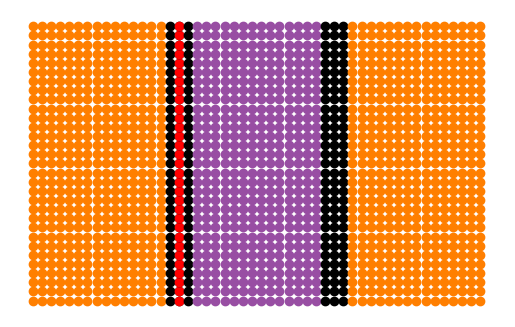

 74%|███████▎  | 14/19 [16:58<07:11, 86.37s/it]

	J/t = 0.06398641295279005


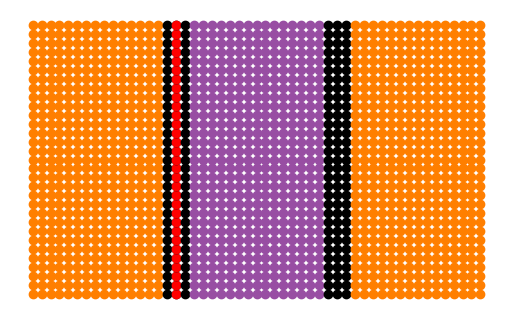

 79%|███████▉  | 15/19 [18:39<06:02, 90.56s/it]

	J/t = -0.06981505266550912


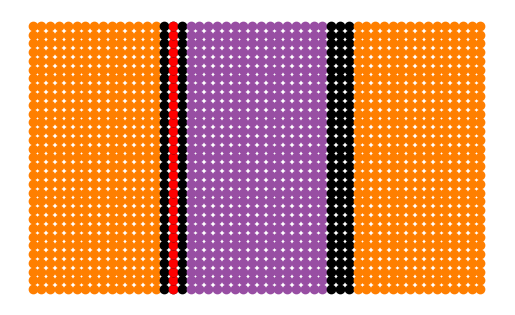

 84%|████████▍ | 16/19 [20:21<04:42, 94.11s/it]

	J/t = 0.02998976617716952


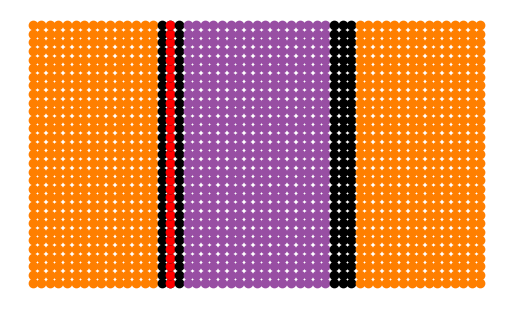

 89%|████████▉ | 17/19 [22:05<03:14, 97.08s/it]

	J/t = -0.012760213375929131


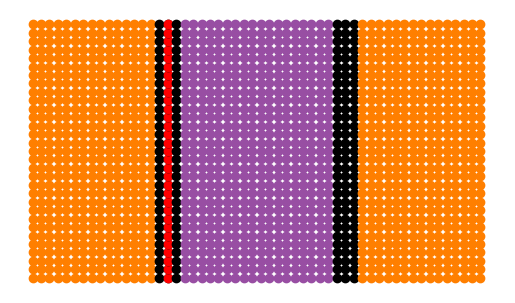

 95%|█████████▍| 18/19 [23:53<01:40, 100.38s/it]

	J/t = -0.010219040152023484


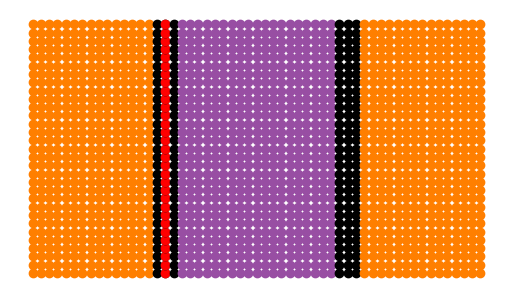

100%|██████████| 19/19 [25:46<00:00, 81.40s/it] 

	J/t = 0.01765342447719743


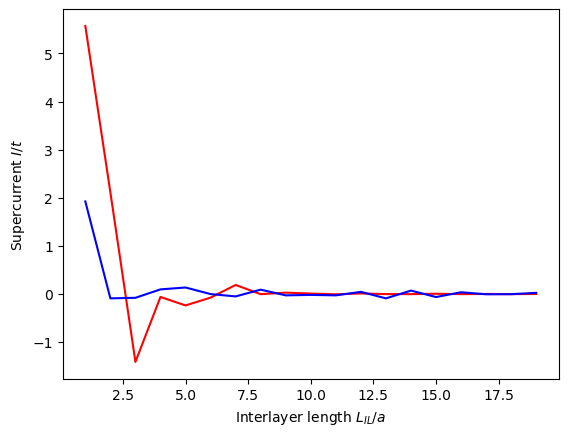

In [32]:
m = 1.5 * t
L_Y = 31
L_SC = 15

LL = []
JJ = []

for DIAG in [True, False]:
    Ls = []
    Js = []

    for L_IL in trange(1, 20):
        L_X = 2 * L_SC + 2 * L_NM + L_IL
        show()

        lattice = CubicLattice((L_X, L_Y, L_Z))
        system = Hamiltonian(lattice)

        with system as (H, Δ, V):
            for i in lattice.sites():
                H[i, i] = -μ * σ0

                if SC1(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((-1j/2) * δφ)
                if SC2(i):
                    Δ[i, i] = Δ0 * jσ2 * np.exp((+1j/2) * δφ)

            for i, j in lattice.bonds(axis=0):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 - m * σ3
                else:
                    H[i, j] = -t * σ0

            for i, j in lattice.bonds(axis=1):
                if IL(i) and IL(j):
                    H[i, j] = -t * σ0 + m * σ3
                else:
                    H[i, j] = -t * σ0
    
        Js.append(current(system))
        Ls.append(L_IL)

        print(f"\tJ/t = {Js[-1]}")

    LL.append(Ls)
    JJ.append(Js)

plt.plot(LL[0], JJ[0], "r", LL[1], JJ[1], "b")
plt.xlabel("Interlayer length $L_{IL}/a$")
plt.ylabel("Supercurrent $I/t$")
plt.show()

**Conclusion:** Diagonal interface alone is insufficient to prevent 0-π oscillations inside of altermagnets. It appears we need to make the whole junction diagonal to prevent them from appearing.

## Lattice construction revised
Let's now revise the lattice construction to make perfectly diagonal junctions, so that we don't accidentally get too much x-focused transport.